In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.stats import uniform, randint
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

import xgboost as xgb
from sklearn.model_selection import (
    KFold,
    GridSearchCV,
    RepeatedKFold,
    cross_val_score,
    train_test_split,
    RandomizedSearchCV
)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import make_pipeline

from utils import load_all_images, predict_image

# the number of height & width pixels to resize images to
PIXELS = 50

In [4]:
# settings
plt.show()
plt.rcParams["figure.dpi"] = 170
plt.rcParams["figure.figsize"] = (8, 5)
plt.style.use('seaborn')

In [3]:
X, y = load_all_images(classes=['sunny', 'cloudy'], pixels=PIXELS)
len(X)

12976

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, shuffle=True, random_state=777
)

# Binary Classification `sunny` vs. `cloudy`

## LogisticRegression

### Basic

In [ ]:
# create Logisitc Model
log_model = LogisticRegression(
    max_iter=3000,
    verbose=True,
)

result = log_model.fit(X_train, y_train)


Model accuracy: 0.633
Model accuracy: 0.787


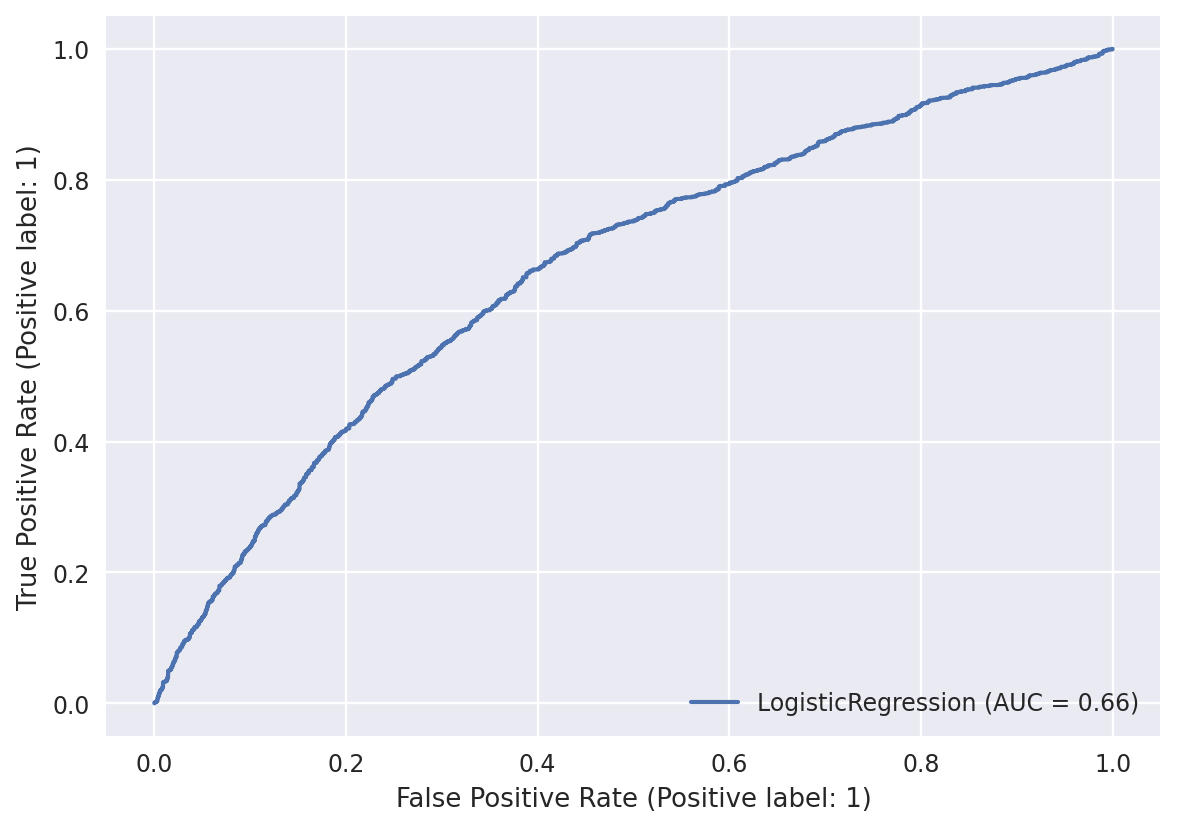

In [176]:
#| echo: false
print(f'Model accuracy: {result.score(X_test, y_test):.3}')
print(f'Model accuracy: {result.score(X_train, y_train):.3}')

RocCurveDisplay.from_estimator(result, X_test, y_test)
plt.show()

### Tuning

In [ ]:
# create Logisitc Model
log_cv = LogisticRegressionCV(
    cv=5,
    solver="saga",
    scoring="accuracy",
    n_jobs=-1,
    verbose=True,
    max_iter=2000,
)

# train
results = log_cv.fit(X_train, y_train)

Model accuracy: 0.678


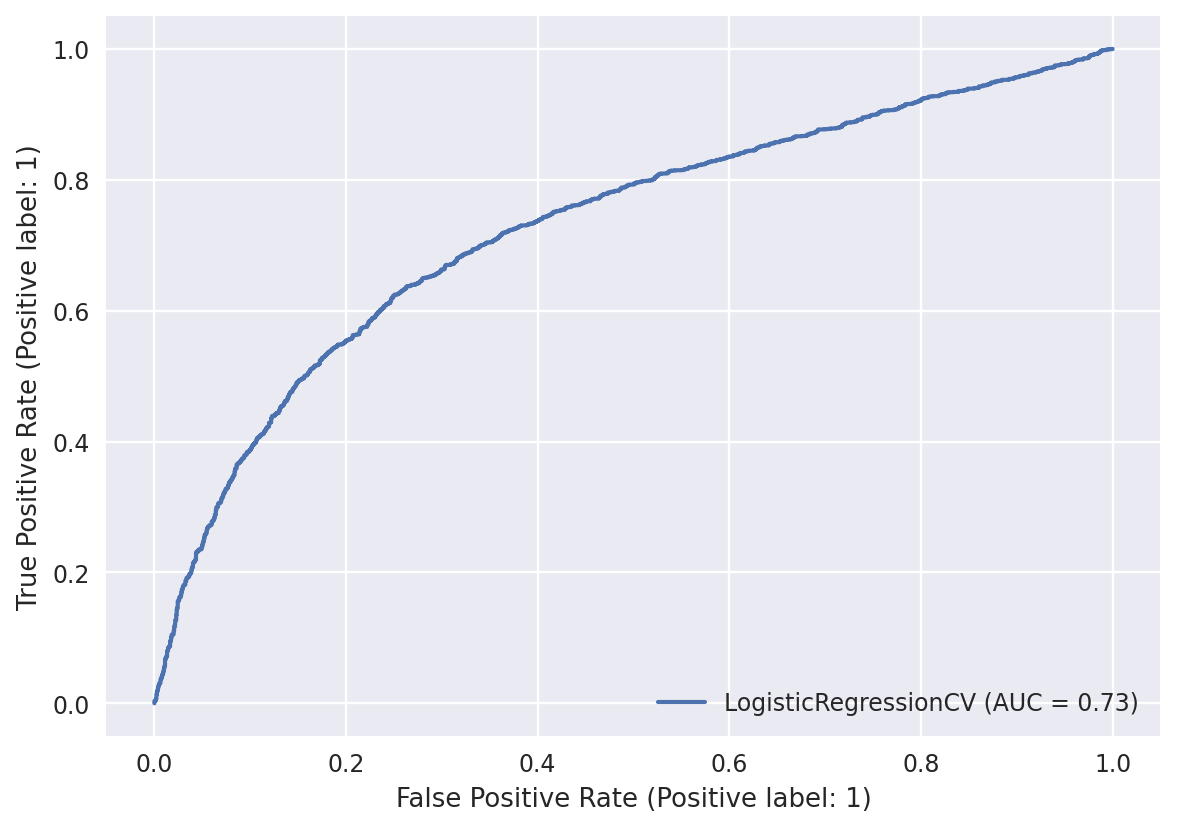

In [175]:
#| echo: false
print(f'Model accuracy: {results.score(X_test, y_test):.3}')

RocCurveDisplay.from_estimator(results, X_test, y_test)
plt.show()

## KNN
### Basic

In [106]:
# create KNN model
knn = KNeighborsClassifier()

knn_result = knn.fit(X_train, y_train)

In [ ]:
#| echo: false
print(f'Model accuracy: {knn_result.score(X_test, y_test):.3}')
print(f'Model accuracy: {knn_result.score(X_train, y_train):.3}')

RocCurveDisplay.from_estimator(knn_result, X_train, y_train)
plt.show()

### Tuning

In [108]:
# create repeated 10-Fold
kfold = RepeatedKFold(n_splits=5, n_repeats=10)

param_grid = {"n_neighbors": range(1, 50, 4)}

knn_search = GridSearchCV(
    knn, param_grid, cv=kfold, scoring="roc_auc", n_jobs=-1
)
result = knn_search.fit(X_train, y_train)

Model accuracy: 0.633
Model accuracy: 0.787


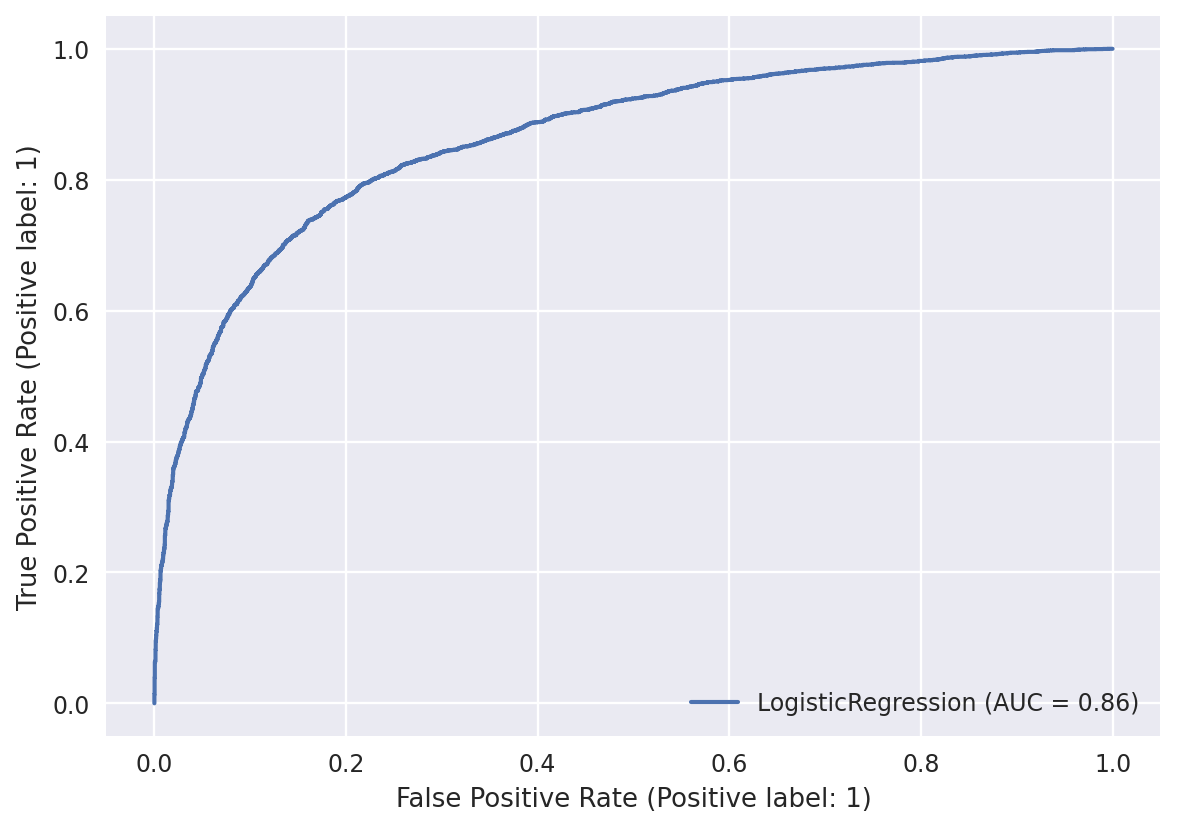

In [178]:
#| echo: false
print(f'Model accuracy: {result.score(X_test, y_test):.3}')
print(f'Model accuracy: {result.score(X_train, y_train):.3}')

RocCurveDisplay.from_estimator(result, X_train, y_train)

plt.show()

## Decision Trees

### Study Effect of CCP

In [92]:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [98]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

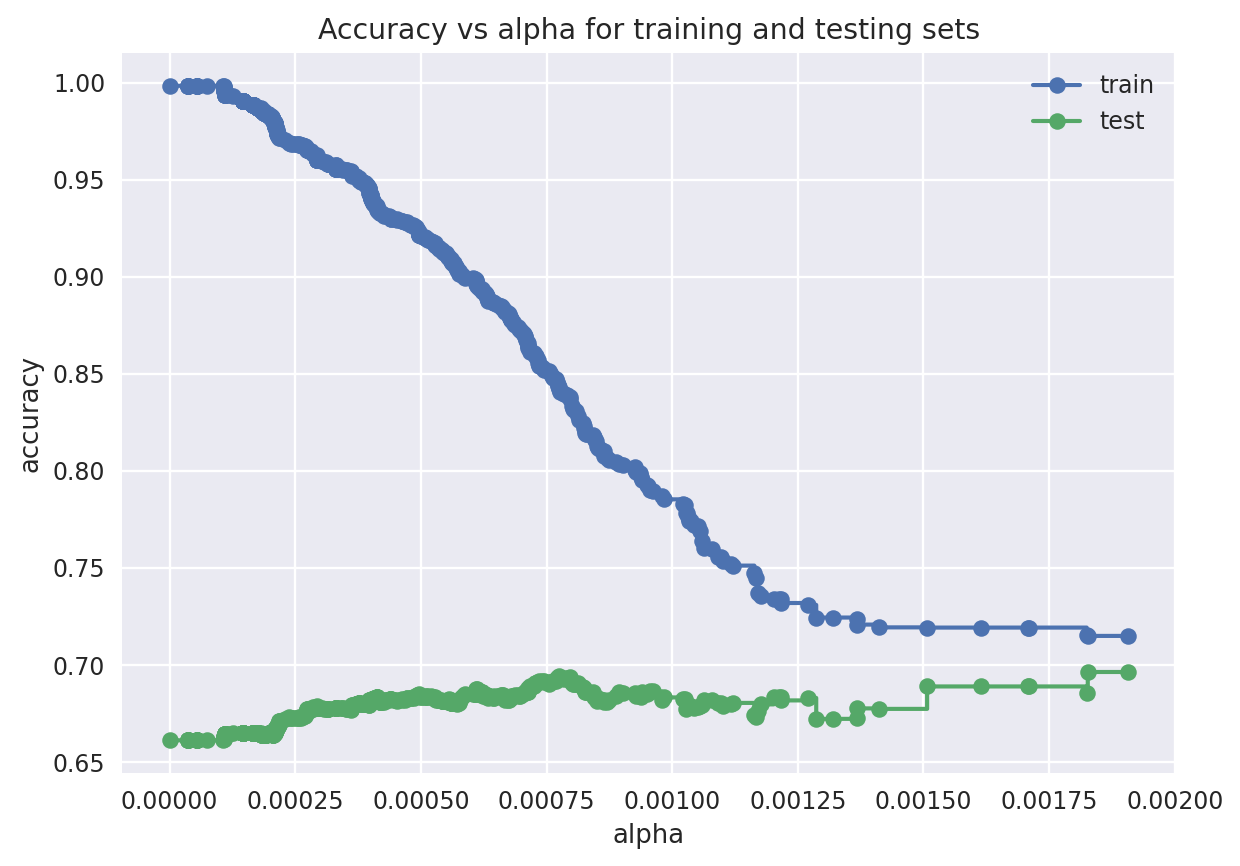

In [180]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas[:-1], train_scores[:-1], marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas[:-1], test_scores[:-1], marker="o", label="test", drawstyle="steps-post")
ax.legend()
# plt.grid(True, which='minor')
# plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.show()

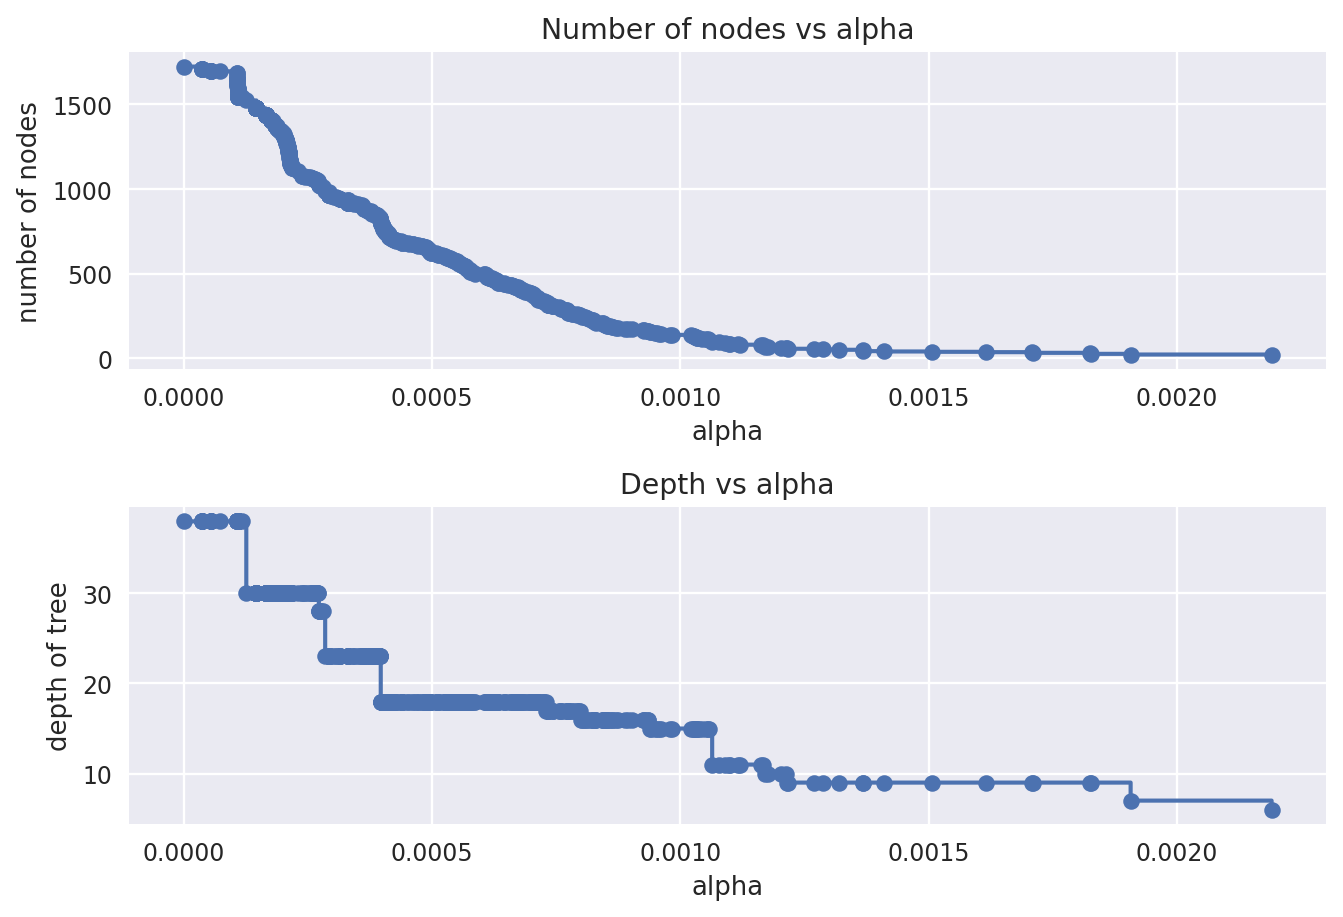

In [121]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

### Basic Tuning

In [ ]:
# create DecisionTree model
dt_model = DecisionTreeClassifier()

# create 5-Fold CV
kfold = KFold(5, shuffle=True)


# GridSearch
dt_search = GridSearchCV(
    dt_model,
    param_grid={
        "max_depth": range(10, 26, 2),
        "min_samples_split": range(2, 11, 2),
        "ccp_alpha": [0.00025, 0.0005, 0.00075, 0.001, 0.00125, 0.0015, 0.00175],
    },
    cv=kfold,
    n_jobs=-1,
    verbose=3,
    scoring="accuracy",
)

dt_result = dt_search.fit(X_train, y_train)

In [184]:
dt_result.best_score_, dt_result.best_params_

(0.6835829743077494,
 {'ccp_alpha': 0.001, 'max_depth': 18, 'min_samples_split': 2})

We saw from the above figure the best `ccp_alpha` value is in the interval \[0.000, 0.002\]

Model accuracy: 0.679


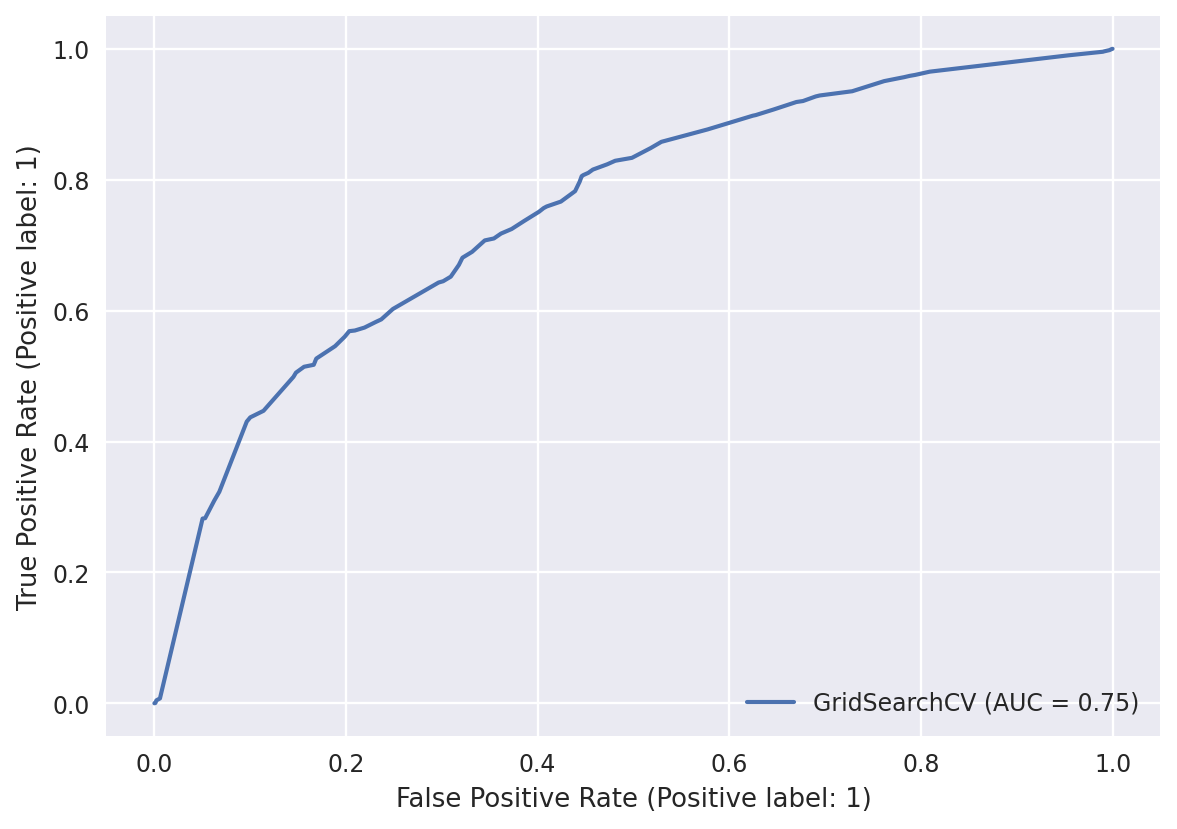

In [187]:
#| echo: false
print(f'Model accuracy: {dt_search.score(X_test, y_test):.3}')

RocCurveDisplay.from_estimator(dt_search, X_test, y_test)
plt.show()

In [ ]:
# Best model
dt_model = DecisionTreeClassifier(ccp_alpha=0.00075)
dt_model.fit(X_train, y_train)

dt_model.score(X_test, y_test)

0.6907269458001541

### With Bagging

In [ ]:
dt_bagging = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=10,
)

dt_bagging_scores = cross_val_score(
    dt_bagging,
    X_train,
    y_train,
    cv=10,
    scoring="accuracy",
    n_jobs=-1,
    verbose=3,
)

In [43]:
print(f"{dt_bagging_scores.mean():0.2f} accuracy with a standard deviation of {dt_bagging_scores.std():0.2f}")

0.71 accuracy with a standard deviation of 0.01


### Tuning with `RandomizedSearchCV`

In [ ]:
dt_bagging = BaggingClassifier(
    DecisionTreeClassifier(),
)

param_distributions = {
    'base_estimator__ccp_alpha': uniform(0.0, 0.001),
    'base_estimator__min_samples_split': range(2, 20, 2),
    'base_estimator__max_depth': range(10, 35),
    'n_estimators': range(5, 30),
}

random_search = RandomizedSearchCV(
    dt_bagging,
    param_distributions,
    cv=10,
    n_iter=20,
    n_jobs=-1,
    verbose=3,
    scoring='accuracy',
)

random_search_results = random_search.fit(X_train, y_train)

In [10]:
print(f"Best Score: {random_search_results.best_score_:0.2f}")
random_search_results.best_estimator_

Best Score: 0.73


BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0008401410500706274,
                                                        max_depth=27,
                                                        min_samples_split=6),
                  n_estimators=26)

## Random Forests
### Basic

In [ ]:
rf_model = RandomForestClassifier()

rf_scores = cross_val_score(
    rf_model,
    X_train,
    y_train,
    cv=10,
    scoring="accuracy",
    n_jobs=-1,
    verbose=3,
)

In [15]:
print(f"{rf_scores.mean():0.2f} accuracy with a standard deviation of {rf_scores.std():0.2f}")

0.74 accuracy with a standard deviation of 0.01


### Tuning with `RandomizedSearchCV`

In [ ]:
rf_model = RandomForestClassifier()

param_distributions = {
    "max_features": uniform(0.05, 0.35),
    "min_samples_leaf": randint(1, 9),
    "max_samples": uniform(0.5, 0.3),
}

rf_random_search = RandomizedSearchCV(
    rf_model,
    param_distributions,
    cv=10,
    n_iter=20,
    n_jobs=-1,
    verbose=3,
    scoring="accuracy",
)

rf_random_result = rf_random_search.fit(X_train, y_train)

In [25]:
print(f"Best Score: {random_search_results.best_score_:0.2f}")
rf_random_result.best_estimator_

Best Score: 0.73


RandomForestClassifier(max_features=0.23303817510595698,
                       max_samples=0.7427985486669761, min_samples_leaf=8)

## Gradient Boosting

In [ ]:
# create Gradient Boosting model
xgb_model = xgb.XGBClassifier()

xgb_scores = cross_val_score(
    xgb_model,
    X_train,
    y_train,
    cv=10,
    n_jobs=-1,
    verbose=3,
    scoring='accuracy',
)

In [9]:
print(f"{xgb_scores.mean():0.2f} accuracy with a standard deviation of {xgb_scores.std():0.2f}")

0.74 accuracy with a standard deviation of 0.02


### Tuning

In [ ]:
param_distributions = {
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 15),
    'n_estimators': randint(1000, 5000),
    'learning_rate': uniform(0.001, 0.1),
}

xgb_random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions,
    cv=10,
    n_iter=10,
    n_jobs=-1,
    verbose=3,
    scoring="accuracy",
)

xgb_random_result = xgb_random_search.fit(X_train, y_train)

In [15]:
print(f"Best Score: {xgb_random_result.best_score_:0.2f}")
xgb_random_result.best_params_

Best Score: 0.76


{'learning_rate': 0.031211714406977634,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 1707}

### Stochastic Gradient Boosting
Using the parameters from the best params achieved in the previous `RandomizedGridCV`.

In [ ]:
# create GBM estimator with best params
best_xgb_model = xgb.XGBClassifier(
    **xgb_random_result.best_params_
)

param_distributions = {
    'subsample': [0.5, 0.75, 1],
    'colsample_bynode': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
    'colsample_bylevel': [0.5, 0.75, 1],
}
# search with 10 random samples
best_xgb_random_search = RandomizedSearchCV(
    best_xgb_model,
    param_distributions,
    cv=5,
    n_iter=10,
    n_jobs=-1,
    verbose=3,
    scoring="accuracy",
)

# train
best_xgb_random_result = best_xgb_random_search.fit(X_train, y_train)

In [19]:
print(f"Best Score: {best_xgb_random_result.best_score_:0.2f}")
best_xgb_random_result.best_params_

Best Score: 0.76


{'subsample': 1,
 'colsample_bytree': 1,
 'colsample_bynode': 0.75,
 'colsample_bylevel': 1}

### Tuning

In [ ]:
# create GBM estimator with best params
tunned_xgb_model = xgb.XGBClassifier(
    learning_rate=0.031211714406977634,
    max_depth=6,
    min_child_weight=3,
    subsample=1,
    colsample_bytree=1,
    colsample_bynode=0.75,
    colsample_bylevel=1,
)

# search with 10 random samples
tunned_xgb_random_search = RandomizedSearchCV(
    tunned_xgb_model,
    param_distributions={
        "n_estimators": range(1000, 5000),
    },
    cv=5,
    n_iter=10,
    n_jobs=-1,
    verbose=3,
    scoring="accuracy",
)

# train
tunned_xgb_random_result = tunned_xgb_random_search.fit(X_train, y_train)

In [16]:
# save the last best XGB model
with open('tunned_xgb_random_result.pickle', 'wb') as file:
    pickle.dump(tunned_xgb_random_result, file)

print(f"Best Score: {tunned_xgb_random_result.best_score_:0.3f}")
tunned_xgb_random_result.best_params_

Best Score: 0.760


{'n_estimators': 3008}

In [2]:
# load model
with open('./tunned_xgb_random_result.pickle', 'rb') as file:
    model: RandomizedSearchCV = pickle.load(file)

## Predict Outside Image

array([0.00233829, 0.9976617 ], dtype=float32)

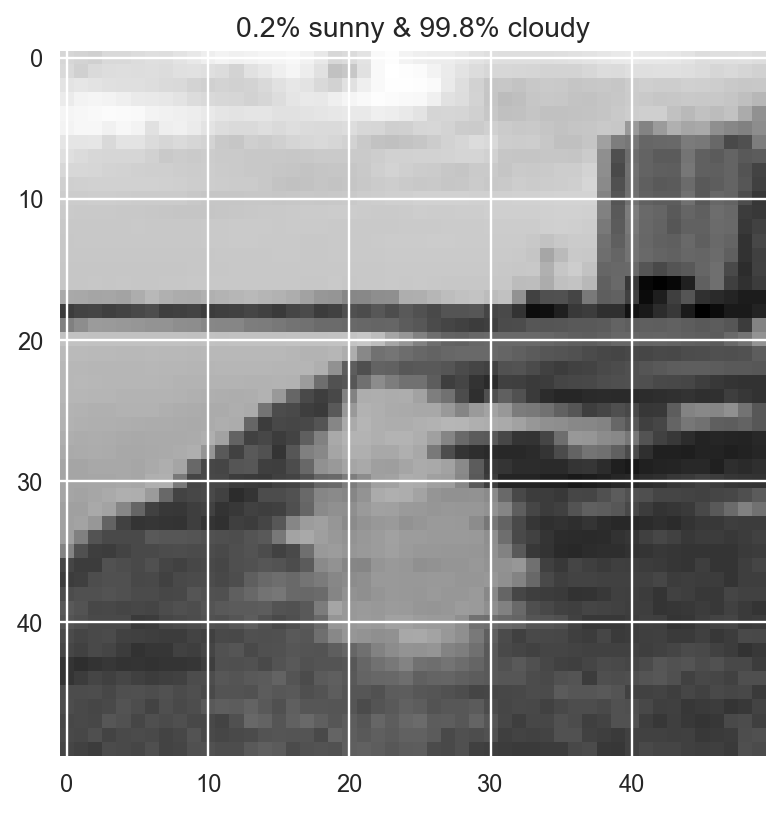

In [5]:
predict_image(model, '../data/IMG_0430.jpeg', show=True)